In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.express as px
from joblib import dump, load
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

# Data exploration


In [11]:
# load dataset
data_frame = pd.read_csv("shuffled-full-set-hashed.csv",header=None);
# check how data looks like
data_frame.head()

,0,1
0,DELETION OF INTEREST,e04a09c87692 d6b72e591b91 5d066f0246f1 ed41171...
1,RETURNED CHECK,a3b334c6eefd be95012ebf2b 41d67080e078 ff1c26e...
2,BILL,586242498a88 9ccf259ca087 54709b24b45f 6bf9c0c...
3,BILL,cd50e861f48b 6ca2dd348663 d38820625542 f077614...
4,BILL,9db5536263d8 1c303d15eb65 3f89b4673455 b73e657...


In [12]:
# Drop NAN values in CSV File
data_frame.dropna(inplace = True)
#change headers of the dataset
data_frame.columns = ['label', 'text']
#check length
len(data_frame)

62159

In [13]:
# Check the number of rows for each label
count = data_frame.groupby(['label']).agg(['count'])
count = count.reset_index()
count.columns = (['label','count'])
count.sort_values(by = ['count'],ascending = False, inplace = True)
fig = px.bar(count, x = 'label', y = 'count',title = 'Number of Observations for Each Label')
fig.show()

In [14]:
count

,label,count
1,BILL,18959
11,POLICY CHANGE,10616
4,CANCELLATION NOTICE,9729
3,BINDER,8952
7,DELETION OF INTEREST,4826
12,REINSTATEMENT NOTICE,4367
6,DECLARATION,967
5,CHANGE ENDORSEMENT,889
13,RETURNED CHECK,749
8,EXPIRATION NOTICE,734


### The dataset has 14 classes in total. From about figure and table, we could see that the dataset has a imbalance problem. The "BILL" has more than 10k observations while "INTENT TO CANCEL NOTICE" only has around 200 observations. The best way to fix the problem is to collect more observations for those labels that only have a few observations. 

# Build and Test the Model

In [16]:
# Generate data for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_frame.text, data_frame.label, 
                                                    test_size = 0.2, random_state = 15,
                                                   stratify = data_frame.label)
# Since the dataset is imbalanced for each classes, we could set stratify = data_frame.label so it is 
# gurantee that for each label, there are going to be 20% of the data go to the test dataset.

In [119]:
# Calculate the TF-IDF frequency of words in the documents.
# Use most frequent 1000 words as features for training
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, decode_error="ignore")
vectorizer.fit(X_train)

TfidfVectorizer(decode_error='ignore', max_features=1000)

In [120]:
#Generate vectorized dataset
X_train_vectorized = vectorizer.transform(X_train)

In [123]:
sparsity = 1.0 - ( X_train_vectorized.count_nonzero() / float(X_train_vectorized.toarray().size) )
print(sparsity)

0.8887787519858427


### Over 88% of the training matrix elements are zero. So it is a high-dimensional sparse matrix. Support vector machine is proved to work well for such high-dimensional sparse matrix

### I choose to use support vector machine with linear kernal. For high-dimensional sparse matrix, there is no need to use non-linear kener to map the data to higher dimensions. 

In [19]:
svc_tfidf = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", max_features=1000)),
        ("linear svc", SVC(kernel="linear"))
    ])

In [6]:
tuned_parameters = [{ 'linear svc__C': [1, 10, 100, 1000]}]
scores = ['precision', 'recall']

In [ ]:
# Use grid search to find the best parameter "C" for the model.
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        svc_tfidf, tuned_parameters, scoring='%s_macro' % score, cv = 2
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

### The result from grid search (check 'gridsearch_report.txt') shows that if we want to achieve better precision, we should should use C = 1, if we want to achieve better recall, we should choose C = 10

In [128]:
# fit the model with C=1 (default value) and use the model to predict test data
model = svc_tfidf
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


0.8654279279279279
                         precision    recall  f1-score   support

            APPLICATION       0.80      0.70      0.74        46
                   BILL       0.90      0.90      0.90      3792
            BILL BINDER       0.45      0.09      0.14        58
                 BINDER       0.84      0.88      0.86      1790
    CANCELLATION NOTICE       0.83      0.86      0.85      1946
     CHANGE ENDORSEMENT       0.91      0.80      0.85       178
            DECLARATION       0.68      0.19      0.29       193
   DELETION OF INTEREST       0.91      0.89      0.90       965
      EXPIRATION NOTICE       0.84      0.71      0.77       147
INTENT TO CANCEL NOTICE       0.50      0.28      0.36        46
     NON-RENEWAL NOTICE       0.89      0.89      0.89       125
          POLICY CHANGE       0.81      0.86      0.84      2123
   REINSTATEMENT NOTICE       0.94      0.94      0.94       873
         RETURNED CHECK       0.98      0.86      0.91       150

    

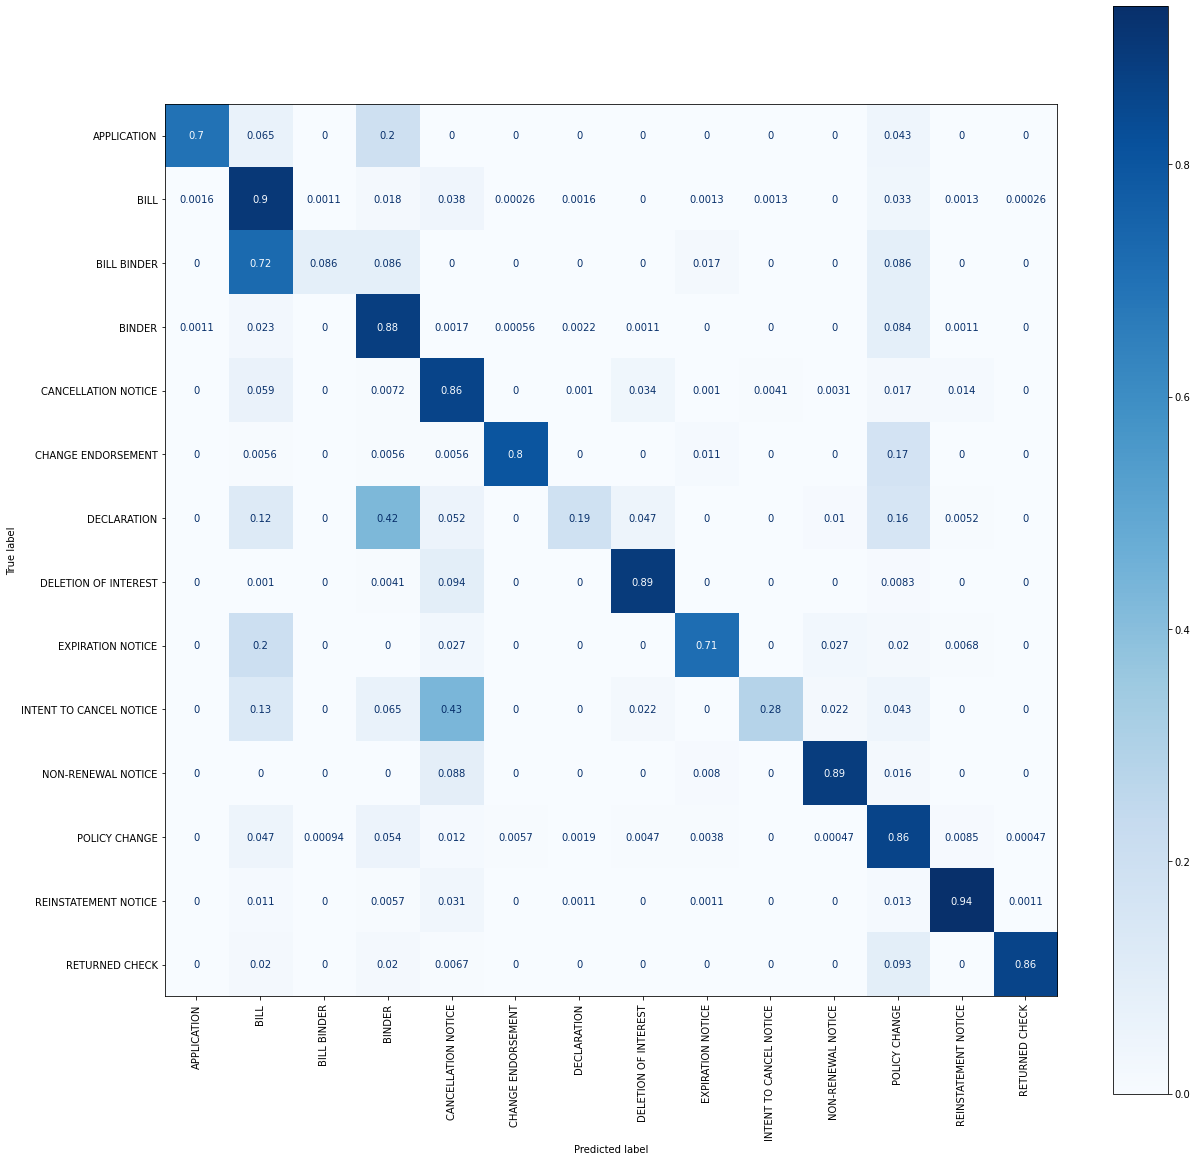

In [143]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(model, X_test, y_test, xticks_rotation = 'vertical', normalize='true', cmap=plt.cm.Blues, ax=ax)
plt.show()

### The model shows good performance on those classes with large observation size, such as "Bill", "Policy Change", and "Binder". 

### We could also notice the model performs well on some classes with small dataset size such as "Returned check", "Change Endorsement", "Application" and "Expiration Notice". One possible reasons is that these documents have some unique words that could help model to differentiate them. 

### It looks like the model misclassifies many "Intend to Cancel Notice" documents and "Cancellation Notice" documents with each other. This is also true for "Bill" and "Bill Binder". From the label name of these documents, we could speculate that these documents use a lot of similar words. The model probably need more data to be able to differentiate them.  

In [144]:
# save the model for future reference
dump(model, 'model_training_data_svc_linear_C_1.joblib')

['model_training_data_svc_linear_C_1.joblib']

# Model for deployment

In [145]:
#Retrain the model on the whole dataset for deployment

In [149]:
# Train the model with Probability equals to True, so the output could include a confidence score
# Internally use 5-fold cross-validation
model_deploy = Pipeline([
        ("tfidf_vectorizer", TfidfVectorizer(stop_words="english", max_features=1000)),
        ("linear svc", SVC(kernel="linear", probability = True, C=1))
    ])

In [151]:
# Train the model
model_deploy.fit(data_frame.text, data_frame.label)

Pipeline(steps=[('tfidf_vectorizer',
                 TfidfVectorizer(max_features=1000, stop_words='english')),
                ('linear svc', SVC(kernel='linear', probability=True))])

In [152]:
# Save the model
dump(model_deploy, 'model_whole_dataset_svc_linear_C_1.joblib')

['model_whole_dataset_svc_linear_C_1.joblib']

In [190]:
# Make predictions with probablity 
predictions = model_deploy.predict_proba(X_test[0:5])

In [191]:
predictions

array([[4.38911175e-05, 9.63907870e-01, 8.01479622e-04, 1.45743316e-03,
        4.87806577e-03, 2.77568824e-03, 1.75551513e-02, 6.02093809e-04,
        3.04644856e-04, 8.49906314e-05, 2.78495187e-05, 7.15939938e-03,
        3.00582306e-04, 1.00860669e-04],
       [5.14432195e-05, 9.78992516e-01, 6.73964113e-04, 3.86306870e-04,
        8.30995708e-03, 4.45025787e-05, 3.92822506e-03, 6.54061368e-05,
        3.67505697e-03, 1.78085191e-04, 1.55024086e-05, 1.79898362e-03,
        4.88210726e-04, 1.39183961e-03],
       [1.03309336e-04, 1.51456971e-02, 1.80488063e-04, 9.09381043e-01,
        6.36576409e-03, 1.39915855e-03, 1.74882840e-02, 1.33206126e-03,
        2.84569684e-03, 2.71962385e-04, 3.74078472e-04, 4.02042957e-02,
        4.68650158e-03, 2.21659189e-04],
       [1.09198658e-03, 1.10662420e-02, 2.60869435e-03, 3.38375743e-01,
        6.42093587e-03, 1.86261299e-03, 5.80064993e-02, 9.83079705e-04,
        1.61001209e-04, 1.14565329e-04, 1.05094734e-04, 5.78395281e-01,
        3.321

In [ ]:
# The returned columns correspond to the classes in sorted order, as they appear in the attribute classes_.

In [187]:
model_deploy.classes_

array(['APPLICATION', 'BILL', 'BILL BINDER', 'BINDER',
       'CANCELLATION NOTICE', 'CHANGE ENDORSEMENT', 'DECLARATION',
       'DELETION OF INTEREST', 'EXPIRATION NOTICE',
       'INTENT TO CANCEL NOTICE', 'NON-RENEWAL NOTICE', 'POLICY CHANGE',
       'REINSTATEMENT NOTICE', 'RETURNED CHECK'], dtype=object)

In [194]:
# Print out the predicted class with highest probablity for each sample
for prediction in predictions:
    print(model_deploy.classes_[np.argmax(prediction)])

BILL
BILL
BINDER
POLICY CHANGE
BILL


# Test webservice

### After deployed the model to a flask web application (see application.py), we could test the app by sending the request to the url

In [33]:
# Load some test data for testing
test_data = pd.read_csv('test_cases/X_test_medium.csv',header = None)

In [52]:
test_data.head()

,0
0,b9699ce57810 f0666bdbc8a5 28abccb95d25 cbfb3eb...
1,25c57acdf805 17bc3e95a38f 6fd647aa15b8 fb2cd24...
2,2b5eec85d917 62b0dcc925a6 9bc65adc033c 7de8072...
3,674c904f1620 5b040684b216 557ec6c63cf9 d388206...
4,72727e621313 288ccf089872 bad6ff5dd7bc c9c2801...


In [53]:
# Select an observation
words = test_data.iat[100,0]

In [54]:
words = {'words': words}

In [55]:
# Test on local server
url_1 = 'http://127.0.0.1:5000/predict'

In [56]:
# Test on amazon elasticbeanstalk server
url_2 = 'http://documentclassification-env-1.eba-u5nvpkwp.us-east-1.elasticbeanstalk.com/predict'

In [57]:
import requests

In [58]:
r = requests.post(url_2,json=words)

In [59]:
print(r.json())

{'confidence': '87%', 'prediction': 'CANCELLATION NOTICE'}
